## Overview

In this notebook, I've trained a linear model, MLP, and LSTM on the Weinstock2016 dataset. 

The data is from the Weinstock2016 dataset with ~200 subjects. The only covariate for now is time which is split into year, month, hour, and minute. All models are designed to take in 196 measurements and predict the next 24. 

In [1]:
# load libraries 
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

sys.path.insert(1, '..')
os.chdir('..')

from data_formatters.weinstock2016 import *
from dataset import TSDataset
from conf import Conf
from models.mlp import *
from models.lstm import *

In [2]:
# loading the config file, setting the experiment name, and the seed for random pre-processing parts (like splitting)
cnf = Conf(conf_file_path='./conf/weinstock.yaml', seed=15, exp_name="Weinstock", log=False)

In [3]:
# call the data fromatter directly
data_formatter = WeinstockFormatter(cnf)

Dropped segments: 1012
Extracted segments: 1085


In [4]:
# extract train, val, and test datasets
train_dataset = TSDataset(cnf, data_formatter, data_formatter.train_data)
val_dataset = TSDataset(cnf, data_formatter, data_formatter.val_data)
test_dataset = TSDataset(cnf, data_formatter, data_formatter.test_data)

Getting valid sampling locations.
# available segments=252901
Extracting 5000 samples out of 252901
1000 of 5000 samples done...
2000 of 5000 samples done...
3000 of 5000 samples done...
4000 of 5000 samples done...
5000 of 5000 samples done...
Getting valid sampling locations.
# available segments=474
Extracting all available segments.
Getting valid sampling locations.
# available segments=44660
Extracting 5000 samples out of 44660
1000 of 5000 samples done...
2000 of 5000 samples done...
3000 of 5000 samples done...
4000 of 5000 samples done...
5000 of 5000 samples done...


In [5]:
# plot inputs and outputs to check for issues
for i in range(1):
    x = test_dataset[i]['inputs']
    print(x[0, :])
    y = test_dataset[i]['outputs']

    # plt.plot(x[:, 5])
    # plt.plot(x[:, 5])
    # plt.plot(y)
    plt.show()

[1.         0.         0.46666667 0.         0.8181818  0.46132597]


In [6]:
x = train_dataset[i]['inputs']
x[:, 0].max()

1.0

[1.         0.         0.46666667 0.         0.8181818  0.46132597]


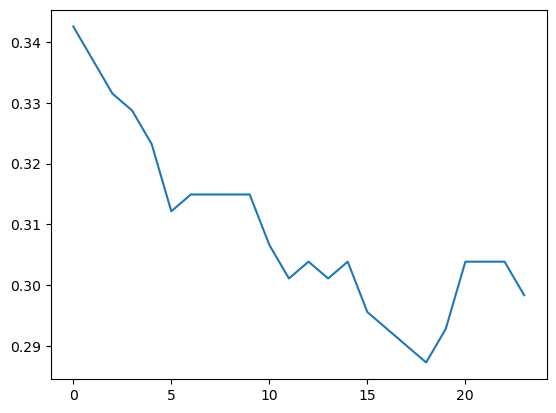

[1.         0.         0.03333334 0.4347826  0.27272728 0.41712707]


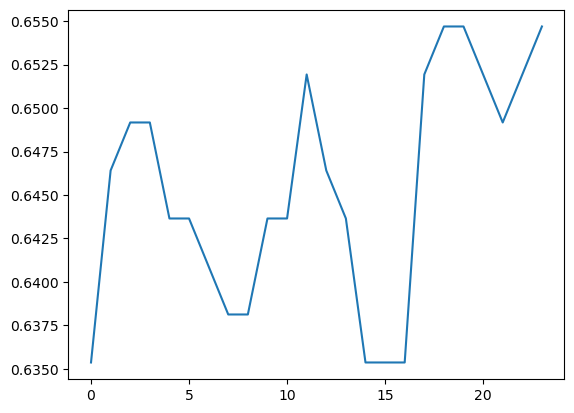

[1.         0.         0.06666667 0.08695652 0.45454547 0.11049724]


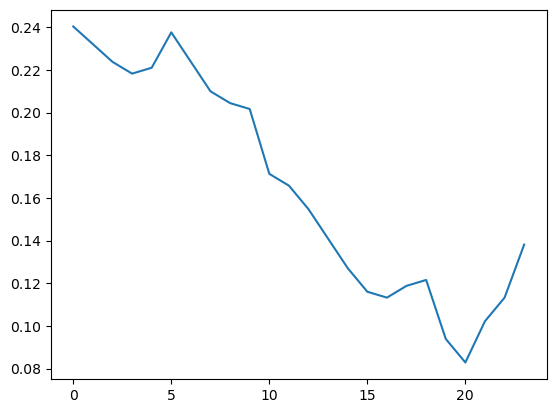

[1.         0.         0.06666667 0.04347826 0.         0.30110496]


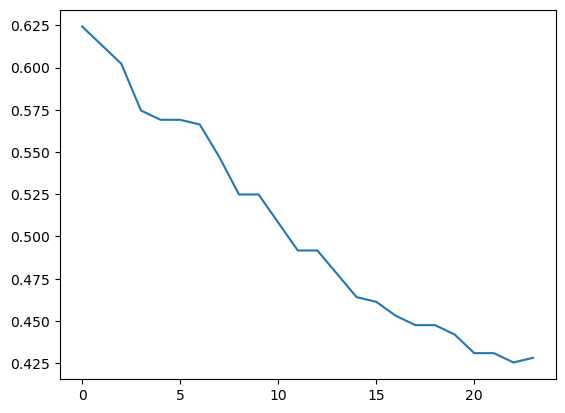

[1.         0.         0.3        0.6956522  0.36363637 0.2596685 ]


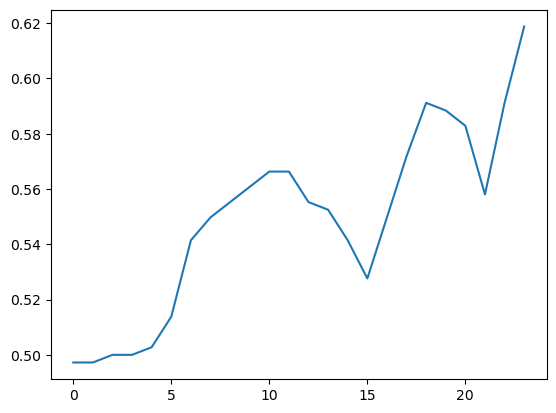

In [7]:
# plot inputs and outputs to check for issues
for i in range(5):
    x = test_dataset[i]['inputs']
    print(x[0, :])
    y = test_dataset[i]['outputs']

    # plt.plot(x[:, 5])
    # plt.plot(x)
    plt.plot(y)
    plt.show()

In [8]:
# set up torch dataloader
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Linear regression

This is just a linear regression model. The first linear layer (linear_collapse) takes the X matrix from 192x6 to 192x1. After squeezing to a $vector \in R^{192}$, it is passed to the actual linear layer (linear) going from $R^{192}$ to $R^{24}$.

In [11]:
class LinearModel(torch.nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear_collapse = torch.nn.Linear(6, 1)
        self.linear = torch.nn.Linear(192, 24)
        
    def forward(self, x):
        y_pred = self.linear(torch.squeeze(self.linear_collapse(x)))
        return y_pred

In [12]:
# train model
best_loss = 1e1000
model = LinearModel()
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
for epoch in range(2):
    for i, d in enumerate(train_loader):
        # Forward pass
        outputs = model(d.get('inputs'))
        loss = criterion(outputs, torch.squeeze(d.get('outputs')))
        
        # Backward and optimize
        optimizer.zero_grad() # zero the gradient buffer
        loss.backward() # compute gradient
        optimizer.step() # update parameters
        
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # validate model
    with torch.no_grad():
        # for i, (inputs, labels) in enumerate(val_loader):
        for i, d in enumerate(val_loader):
            outputs = model(d.get('inputs'))
            loss = criterion(outputs, torch.squeeze(d.get('outputs')))
        print ('Epoch [{}/{}], Val Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # save best model based on val loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), 'best_model_linear.pth')
# load best model
model.load_state_dict(torch.load('best_model_linear.pth'))

Epoch [1/100], Loss: 0.1094
Epoch [1/100], Val Loss: 0.2369
Epoch [2/100], Loss: 0.0555
Epoch [2/100], Val Loss: 0.1828


<All keys matched successfully>

In [13]:
# evaluate model on test set
with torch.no_grad():
    for i, d in enumerate(test_loader):
        outputs = model(d.get('inputs'))
        loss = criterion(outputs, torch.squeeze(d.get('outputs')))
    print ('Epoch [{}/{}], Test Loss: {:.4f}'.format(epoch+1, 100, loss.item()))

Epoch [2/100], Test Loss: 0.1451


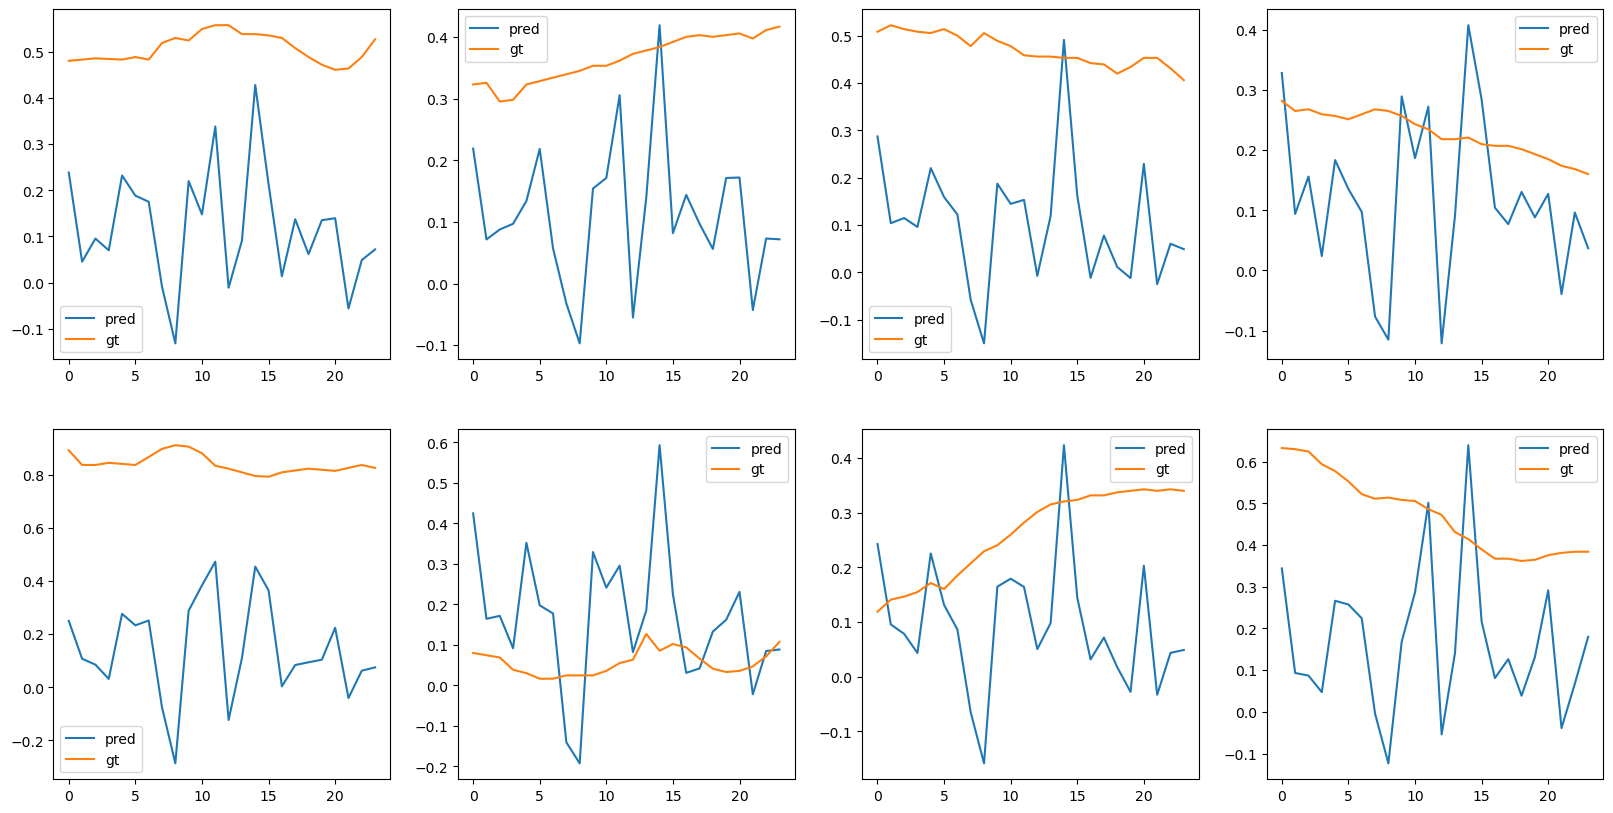

In [14]:
# plots the predictions vs the ground truth
import matplotlib.pyplot as plt
labels = d.get('outputs')
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(2):
    for j in range(4):
        ax[i, j].plot(outputs[i*4+j, :], label='pred')
        ax[i, j].plot(labels[i*4+j, :], label='gt')
        ax[i, j].legend()

## MLP

Training an MLP using the MLP class defined in models/mlp. To use the first original MLP, simply uncomment the block below.

In [ ]:
# # define model
# class MLP(torch.nn.Module):
#     def __init__(self, n1):
#         super(MLP, self).__init__()
#         self.linear_collapse = torch.nn.Linear(6, 1)
#         self.linear = torch.nn.Linear(192, n1)
#         self.relu = torch.nn.ReLU()
#         self.linear2 = torch.nn.Linear(n1, 24)
        
#     def forward(self, x):
#         y_pred = self.linear2(self.relu(self.linear(torch.squeeze(self.linear_collapse(x)))))
#         return y_pred


In [15]:
# train model
best_loss = 1e10000
model = MLP(192, 6, 24, 36, 3, 0.3)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
for epoch in range(3):
    # for i, (inputs, labels) in enumerate(train_loader):
    for i, d in enumerate(train_loader):
        # Forward pass
        outputs = model(d.get('inputs'))
        loss = criterion(outputs, torch.squeeze(d.get('outputs')))
        
        # Backward and optimize
        optimizer.zero_grad() # zero the gradient buffer
        loss.backward() # compute gradient
        optimizer.step() # update parameters
        
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # validate model
    with torch.no_grad():
        # for i, (inputs, labels) in enumerate(val_loader):
        for i, d in enumerate(val_loader):
            outputs = model(d.get('inputs'))
            loss = criterion(outputs, torch.squeeze(d.get('outputs')))
        print ('Epoch [{}/{}], Val Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # save best model based on val loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), 'best_model_mlp.pth')
# load best model
model.load_state_dict(torch.load('best_model_mlp.pth'))

Epoch [1/100], Loss: 0.2054
Epoch [1/100], Val Loss: 0.2732
Epoch [2/100], Loss: 0.2658
Epoch [2/100], Val Loss: 0.2667
Epoch [3/100], Loss: 0.1820
Epoch [3/100], Val Loss: 0.2618


<All keys matched successfully>

In [16]:
# evaluate model on test set
with torch.no_grad():
    for i, d in enumerate(test_loader):
        outputs = model(d.get('inputs'))
        loss = criterion(outputs, torch.squeeze(d.get('outputs')))
    print ('Epoch [{}/{}], Test Loss: {:.4f}'.format(epoch+1, 100, loss.item()))

Epoch [3/100], Test Loss: 0.2119


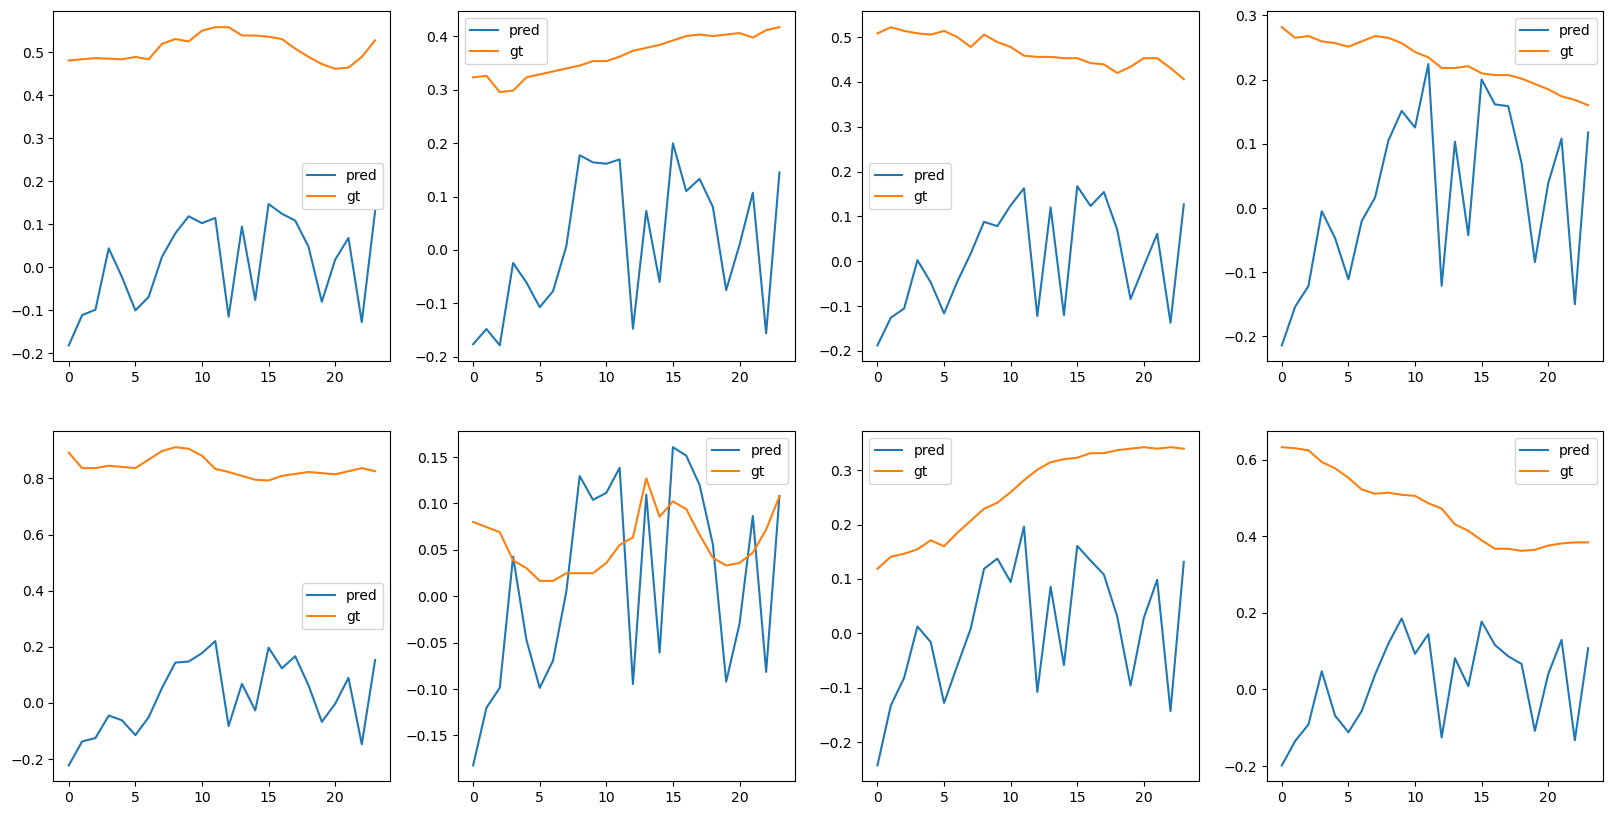

In [17]:
# plots the predictions vs the ground truth
import matplotlib.pyplot as plt
labels = d.get('outputs')
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(2):
    for j in range(4):
        ax[i, j].plot(outputs[i*4+j, :], label='pred')
        ax[i, j].plot(labels[i*4+j, :], label='gt')
        ax[i, j].legend()

## LSTM
Training an LSTM model  

Epoch [1/100], Loss: 0.0355
Epoch [1/100], Val Loss: 0.0630
1
Epoch [2/100], Loss: 0.0774
Epoch [2/100], Val Loss: 0.0617
2
Epoch [3/100], Loss: 0.0774
Epoch [3/100], Val Loss: 0.0616
3


<All keys matched successfully>

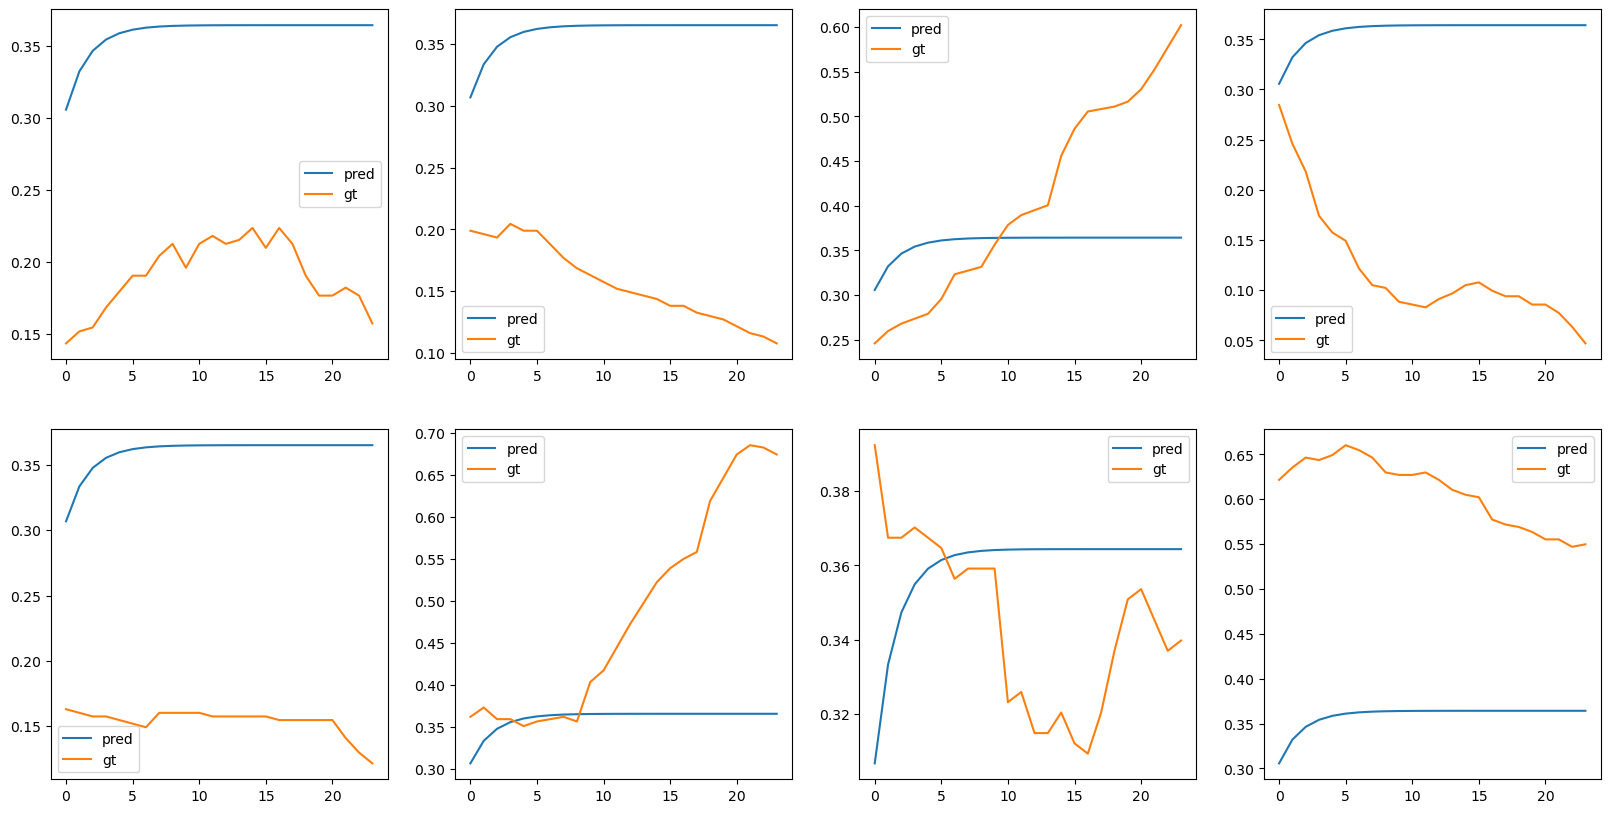

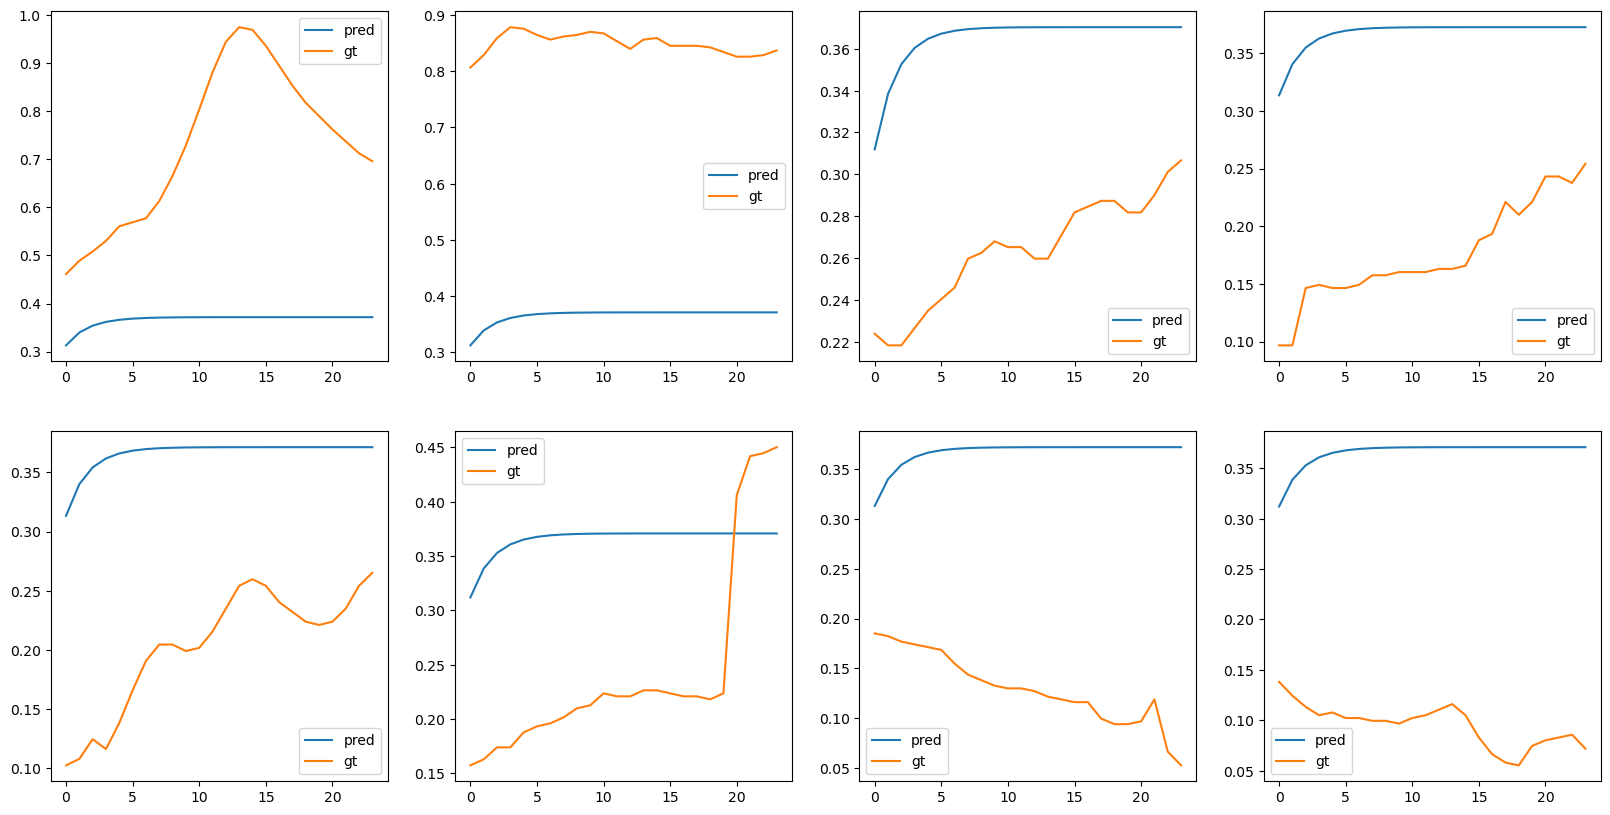

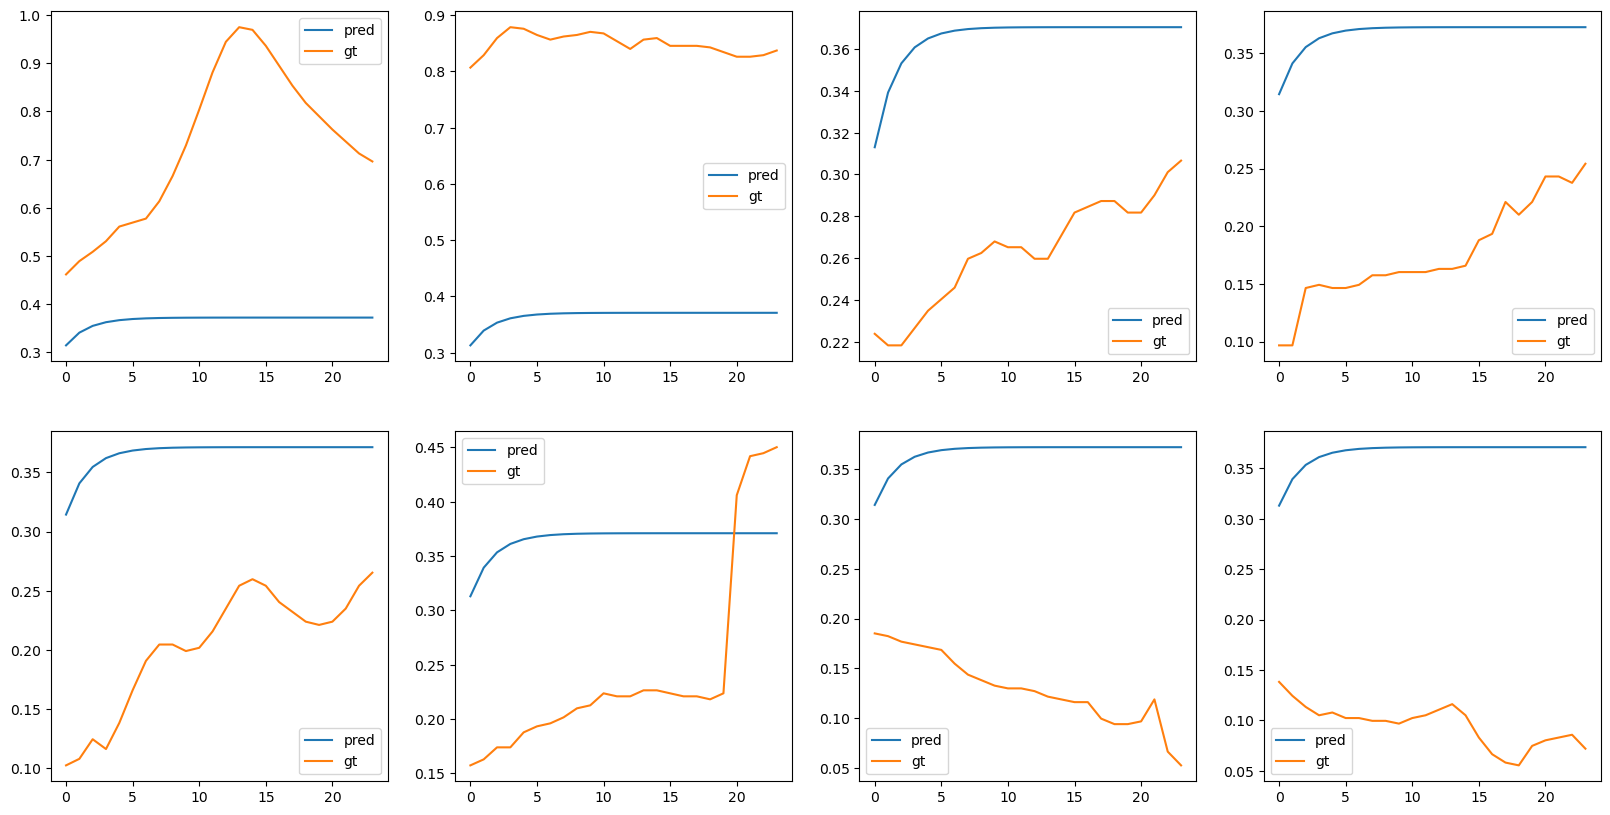

In [18]:
# train model
best_loss = 1e10000
model = LSTM_SeqtoSeq(192, 6, 24, 100)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9) # add a scheduler for learning rate decay
for epoch in range(3):
    for i, d in enumerate(train_loader):
        # Forward pass
        outputs = model(d.get('inputs')) # outputs is a tuple (encoded, decoded) where we want the decoded values
        loss = criterion(outputs[1], d.get('outputs'))
        
        # Backward and optimize
        optimizer.zero_grad() # zero the gradient buffer
        loss.backward() # compute gradient
        optimizer.step() # update parameters
    scheduler.step() # update scheduler

    # plot as the model is training to see the outputs
    y_pred = outputs[1].squeeze().detach().numpy()
    y = d.get('outputs').squeeze().detach().numpy()
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(2, 4, figsize=(20, 10))
    for i in range(2):
        for j in range(4):
            ax[i, j].plot(y_pred[i*4+j, :], label='pred')
            ax[i, j].plot(y[i*4+j, :], label='gt')
            ax[i, j].legend()
        
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # validate model
    with torch.no_grad():
        # for i, (inputs, labels) in enumerate(val_loader):
        for i, d in enumerate(val_loader):
            outputs = model(d.get('inputs'))
            loss = criterion(outputs[1], d.get('outputs'))
        print ('Epoch [{}/{}], Val Loss: {:.4f}'.format(epoch+1, 100, loss.item()))
    # save best model based on val loss
    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(model.state_dict(), 'best_model_lstm.pth')
        print(epoch+1)
# load best model
model.load_state_dict(torch.load('best_model_lstm.pth'))

In [19]:
# evaluate model on test set
with torch.no_grad():
    for i, d in enumerate(test_loader):
        outputs = model(d.get('inputs'))
        loss = criterion(outputs[1], d.get('outputs'))
    print ('Epoch [{}/{}], Test Loss: {:.4f}'.format(epoch+1, 100, loss.item()))

Epoch [3/100], Test Loss: 0.0520


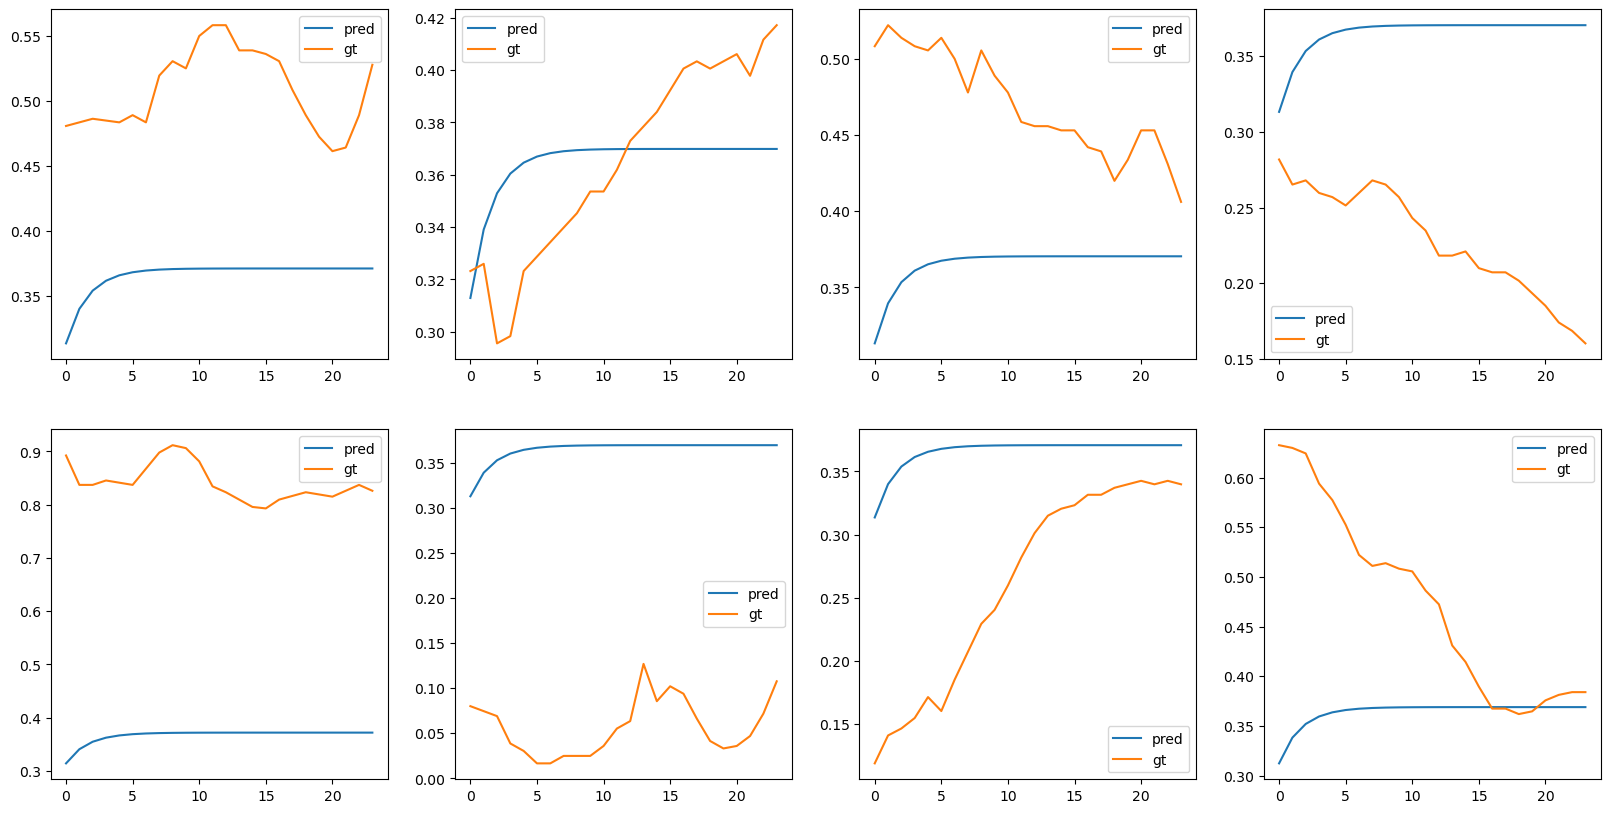

In [20]:
# plots the predictions vs the ground truth
import matplotlib.pyplot as plt
labels = d.get('outputs')
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(2):
    for j in range(4):
        ax[i, j].plot(outputs[1][i*4+j, :], label='pred')
        ax[i, j].plot(labels[i*4+j, :], label='gt')
        ax[i, j].legend()